# **Used Cars Price Predictions** 

### **Importing Required Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sp
from scipy import stats
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost import XGBRegressor
 

import warnings
warnings.filterwarnings('ignore')

### **Loading Data**

In [2]:
df_train = pd.read_csv('./train-data.csv')
df_test = pd.read_csv('./test-data.csv')

In [3]:
# checking the first five rows of training data
df_train.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [4]:
# dropping unnecessary column from both train and test dataset
df_train.drop('Unnamed: 0',axis=1,inplace=True)
df_test.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
# checking the shape of data
df_train.shape

(6019, 13)

In [6]:
# checking the info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 611.4+ KB


**Dataset contains 6019 cars examples and has features like Location, Manufacture details, car features such as Fuel type, Engine, and usage parameters. Some features are numeric attached with units and they need to be removed.**

In [7]:
# checking for any missing value in data
df_train.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

**As we can see that there are missing values in some of the features.**

In [8]:
# lets count uniques values in each column
unique_cnt = list(map(lambda x: len(df_train[x].unique()), list(df_train)))
print('Unique counts in each column:')
dict(zip(list(df_train),unique_cnt))

Unique counts in each column:


{'Name': 1876,
 'Location': 11,
 'Year': 22,
 'Kilometers_Driven': 3093,
 'Fuel_Type': 5,
 'Transmission': 2,
 'Owner_Type': 4,
 'Mileage': 443,
 'Engine': 147,
 'Power': 373,
 'Seats': 10,
 'New_Price': 541,
 'Price': 1373}

### **Data Cleaning**

In [9]:
# Let's Drop those Rows which contains NULL values.
# dropping New_Price as there are many cell which contains NULL value in this column.
df_train.drop('New_Price',axis=1,inplace=True)

df_train.dropna(inplace=True)
print(df_train.shape)

(5975, 12)


### **Feature Engineering**

In [10]:
def remove_units(data,col = None):
    for j in range(len(col)):
        data[col[j]] = data[col[j]].str.split().str[0]
    
remove_units(df_train,col = ['Name','Mileage','Engine','Power'])

In [11]:
df_train.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti,Mumbai,2010,72000,CNG,Manual,First,26.6,998,58.16,5.0,1.75
1,Hyundai,Pune,2015,41000,Diesel,Manual,First,19.67,1582,126.2,5.0,12.50
2,Honda,Chennai,2011,46000,Petrol,Manual,First,18.2,1199,88.7,5.0,4.50
3,Maruti,Chennai,2012,87000,Diesel,Manual,First,20.77,1248,88.76,7.0,6.00
4,Audi,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2,1968,140.8,5.0,17.74


In [12]:
df_train.dtypes

Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage               object
Engine                object
Power                 object
Seats                float64
Price                float64
dtype: object

In [13]:
# changing datatype from string to float
for col in ['Mileage','Engine']:
    df_train[col] = df_train[col].astype(float)

**When I tried to change Power to float an error occured (Can't convert str to float : null). so lets check the problem-**

In [14]:
df_train.Power.unique()

array(['58.16', '126.2', '88.7', '88.76', '140.8', '55.2', '63.1',
       '171.5', '103.6', '74', '103.25', '116.3', '187.7', '115',
       '175.56', '98.6', '83.8', '167.62', '190', '88.5', '177.01', '80',
       '67.1', '102', '108.45', '138.1', '184', '179.5', '103.5', '64',
       '82', '254.8', '73.9', '46.3', '37.5', '77', '82.9', '149.92',
       '138.03', '112.2', '163.7', '71', '105', '174.33', '75', '103.2',
       '53.3', '78.9', '147.6', '147.8', '68', '186', '170', '69', '140',
       '78', '194', '500', '108.5', '86.8', '187.74', 'null', '132',
       '86.7', '73.94', '117.3', '218', '168.5', '89.84', '110', '90',
       '82.85', '67', '241.4', '35', '270.9', '126.32', '73', '130',
       '100.6', '150', '75.94', '215', '107.3', '37.48', '120', '178',
       '152', '91.1', '85.80', '362.07', '121.3', '143', '81.80', '171',
       '76.8', '103.52', '444', '362.9', '67.06', '120.7', '258', '81.86',
       '112', '88.73', '57.6', '157.75', '102.5', '201.1', '83.1',
       '6

**You can see from the above result, a unique value 'null' which is creating a problem.**

In [15]:
df_train[df_train['Power'] == 'null']

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
76,Ford,Jaipur,2008,111111,Diesel,Manual,First,17.80,1399.0,null,5.0,2.00
79,Hyundai,Hyderabad,2005,87591,Petrol,Manual,First,0.00,1086.0,null,5.0,1.30
89,Hyundai,Hyderabad,2007,73745,Petrol,Manual,First,17.00,1086.0,null,5.0,2.10
120,Hyundai,Mumbai,2005,102000,Petrol,Manual,Second,17.00,1086.0,null,5.0,0.85
143,Hyundai,Kochi,2008,80759,Petrol,Manual,Third,17.00,1086.0,null,5.0,1.67
...,...,...,...,...,...,...,...,...,...,...,...,...
5861,Hyundai,Chennai,2007,79000,Petrol,Manual,First,17.00,1086.0,null,5.0,1.85
5873,Hyundai,Pune,2006,47200,Petrol,Manual,Second,17.00,1086.0,null,5.0,1.20
5925,Skoda,Pune,2010,85000,Petrol,Manual,First,17.50,1798.0,null,5.0,2.85
5943,Mahindra,Chennai,2002,75000,Diesel,Manual,First,0.00,2112.0,null,6.0,1.70


In [16]:
## dropping the rows having string null in Power column
null_index = df_train[df_train['Power'] == 'null'].index
df_train.drop(null_index,inplace=True)

In [17]:
# lets check the shape again
df_train.shape

(5872, 12)

In [18]:
df_train['Power'] = df_train['Power'].astype(float)

### **Exploratory Data Analysis**

#### Correlation Analysis

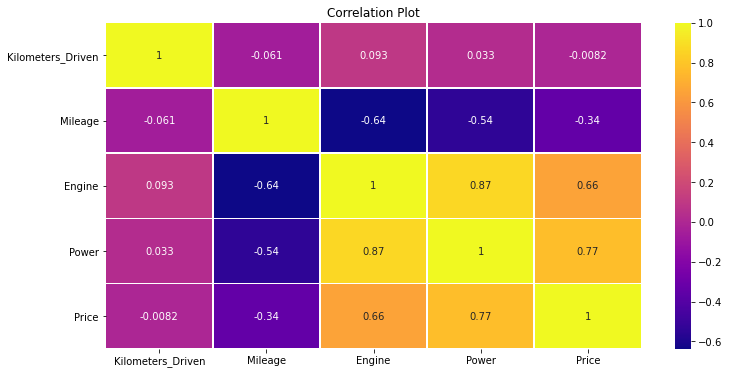

In [19]:
cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power','Price']

plt.figure(figsize=(12,6))
sns.heatmap(df_train[cols].corr(),linewidths=0.5,cmap="plasma", annot=True);
plt.title("Correlation Plot")
plt.show()

* Surprisingly Kilometers_Driven doesn't seem to influence target variable and Mileage negatively affects price which could be result of caustion.
* Both Engine and Power have strong correlation with taget and Also with each other which is pretty inituitive as higher engine capacity imply higher power.
* There exists a multicolinearity between Engine capacity and power.

#### Distribution of Target variable - Price

In [20]:
df_train['Price'].describe()

count    5872.000000
mean        9.603919
std        11.249453
min         0.440000
25%         3.517500
50%         5.750000
75%        10.000000
max       160.000000
Name: Price, dtype: float64

<Figure size 1080x432 with 0 Axes>

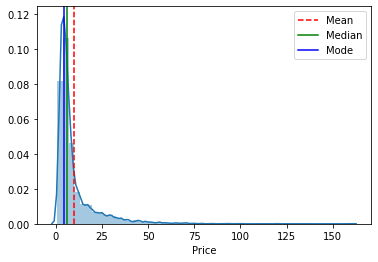

In [21]:
# lets check the distribution of target variable - price
plt.figure(figsize=(15,6))

f,ax = plt.subplots(1, sharex=True,)
mean_price = df_train['Price'].mean()
median_price = df_train['Price'].median()
mode_price = df_train['Price'].mode().values[0]

sns.distplot(df_train['Price'],ax = ax)
ax.axvline(mean_price, color='r', linestyle='--', label="Mean")
ax.axvline(median_price, color='g', linestyle='-', label="Median")
ax.axvline(mode_price, color='b', linestyle='-', label="Mode")

ax.legend()
plt.xlim()
plt.show()

* Majority of cars having price around 5 - 10 Lakh.
* There are very minimum cars having price between 50 lakh to 160 lakh.
* We can see that mean price is greater than median of price, also long tail of distribution is longer on right hand side as compared to left hand side which shows that distribution is positively skewed.

#### Distribution of Continuous Variable- 'Kilometers_Driven','Mileage', 'Engine', 'Power'

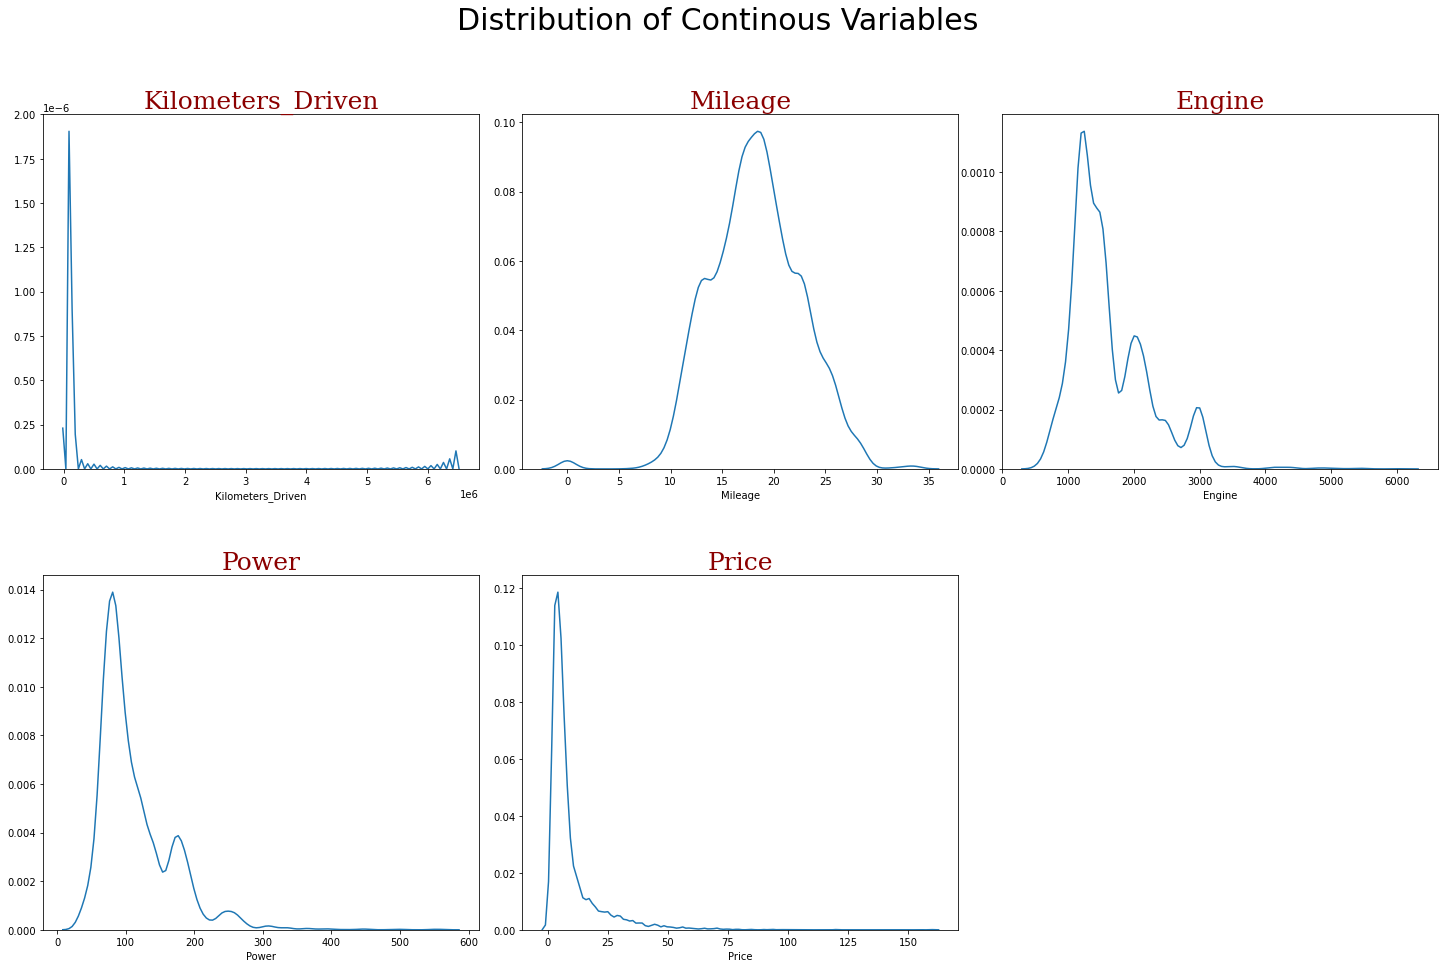

In [22]:
numerical_Features = ['Kilometers_Driven','Mileage', 'Engine', 'Power','Price']
fig,axes = plt.subplots(2,3,figsize=(25,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Distribution of Continous Variables', fontsize=30)
axes = axes.ravel()
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
for i,col in enumerate(numerical_Features):
    sns.distplot((df_train[col][~pd.isna(df_train[col])]), hist= False,ax=axes[i])
    axes[i].set_title(col,fontdict = font, fontsize=25)    
fig.delaxes(axes[-1])

* Except Milage, rest are highly positive skewed. We can transform it to represent a normal distribution.
* Lets try with a very general transformation function log and see if that helps here.

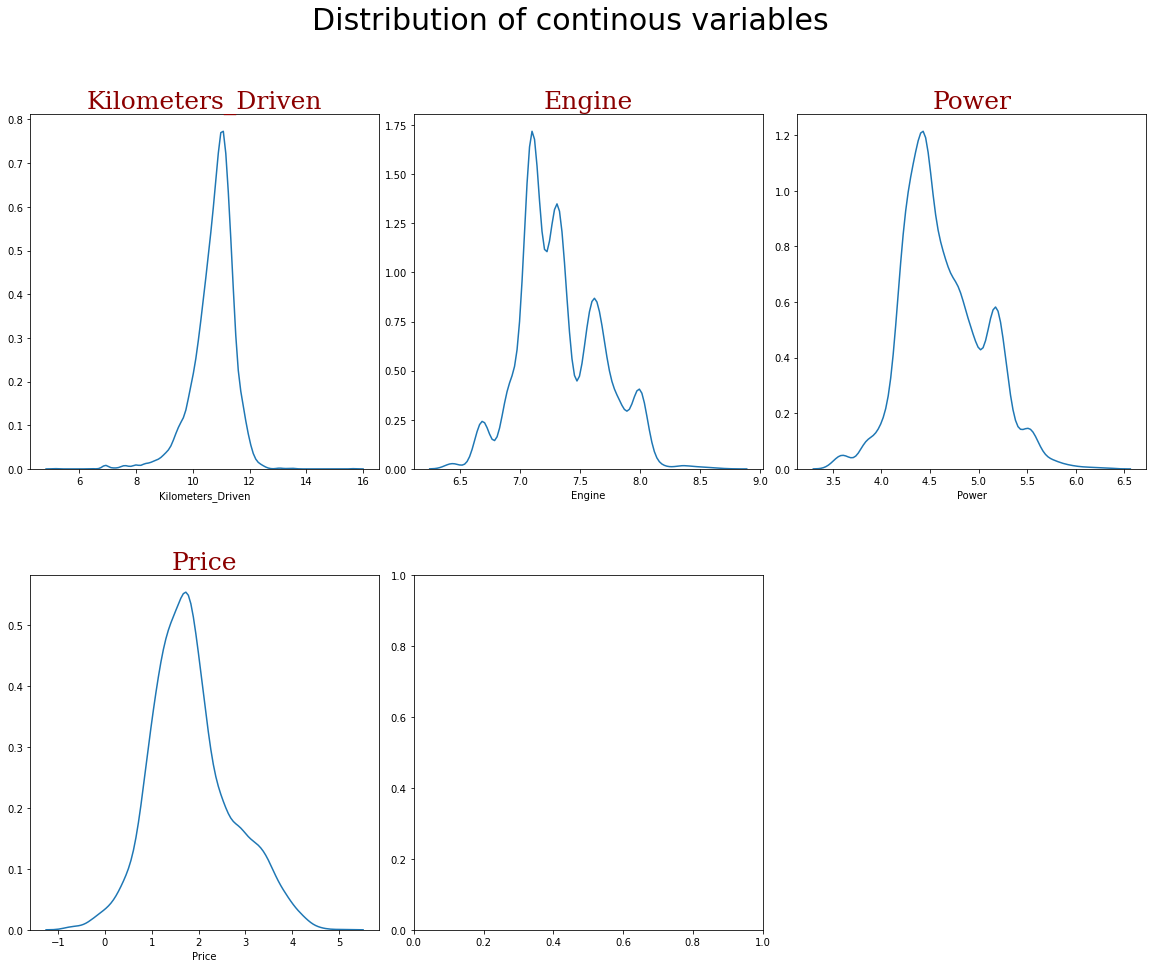

In [23]:
con_cols = ['Kilometers_Driven','Engine', 'Power', "Price"]
fig,axes = plt.subplots(2,3,figsize=(20,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Distribution of continous variables', fontsize=30)
axes = axes.ravel()

for i,col in enumerate(con_cols):
    sns.distplot((df_train[col][~pd.isna(df_train[col])]).apply(np.log), hist= False,ax=axes[i])
    axes[i].set_title(col,fontdict = font, fontsize=25)  
fig.delaxes(axes[-1])

* So with log, the distribution appears close to normal. So we can use this transformation for our numerical features and target variable and move ahead.
* All predictions by the model will then be in log values and we will need to take the antilog to get the actual value.

#### Analysis of Car Brand

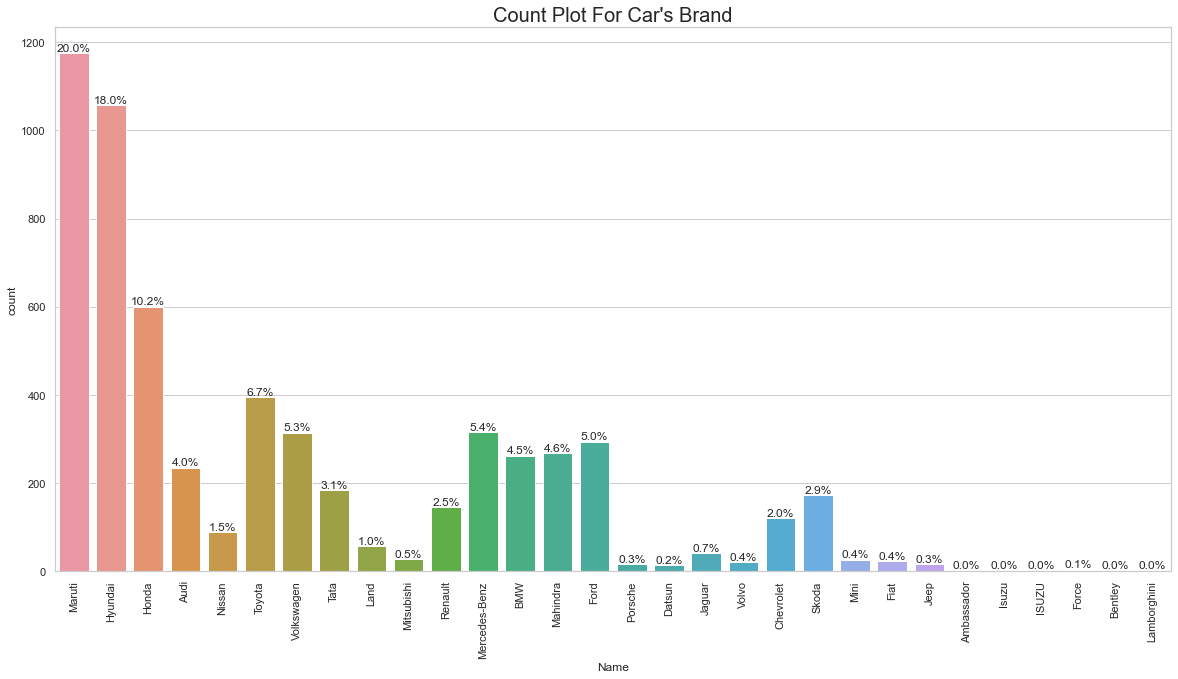

In [24]:
sns.set(style="whitegrid")
plt.figure(figsize=(20,10))
total = float(len(df_train))
ax = sns.countplot(x="Name", data=df_train)
plt.xticks(rotation=90)
plt.title("Count Plot For Car's Brand", fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2.
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center',va='bottom')
plt.show()

* Cleary Maruti is most comman brand followed by Hyundai.

#### Analysis of Price across cities

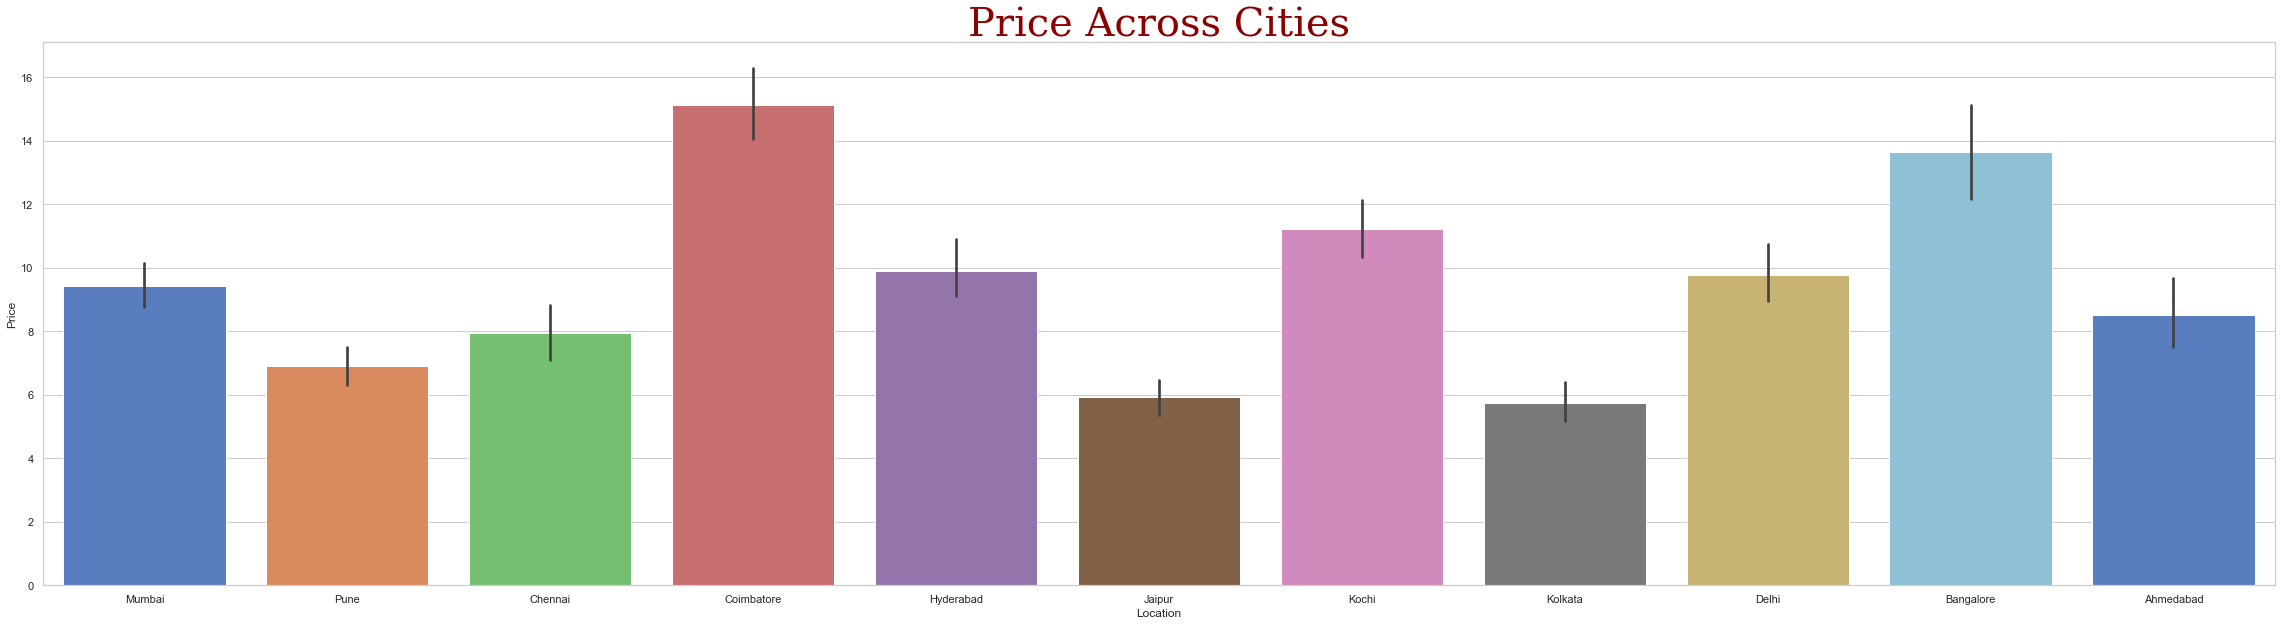

In [25]:
plt.figure(figsize=(40,10))
sns.barplot(x="Location", y="Price", data=df_train,palette="muted")
plt.title("Price Across Cities",fontdict = font, fontsize=40)
plt.show()

* From the above Plot, Coimbatore is highest in paying for used cars, and Jaipur and Kolkata lowest. This could mean coimbatore is paying comparitively higher prices or coimbatore is in forefront in buying expensive cars which pushes the city to the top and vice versa for Jaipur and Kolkata.

#### Analysis of Price and Year

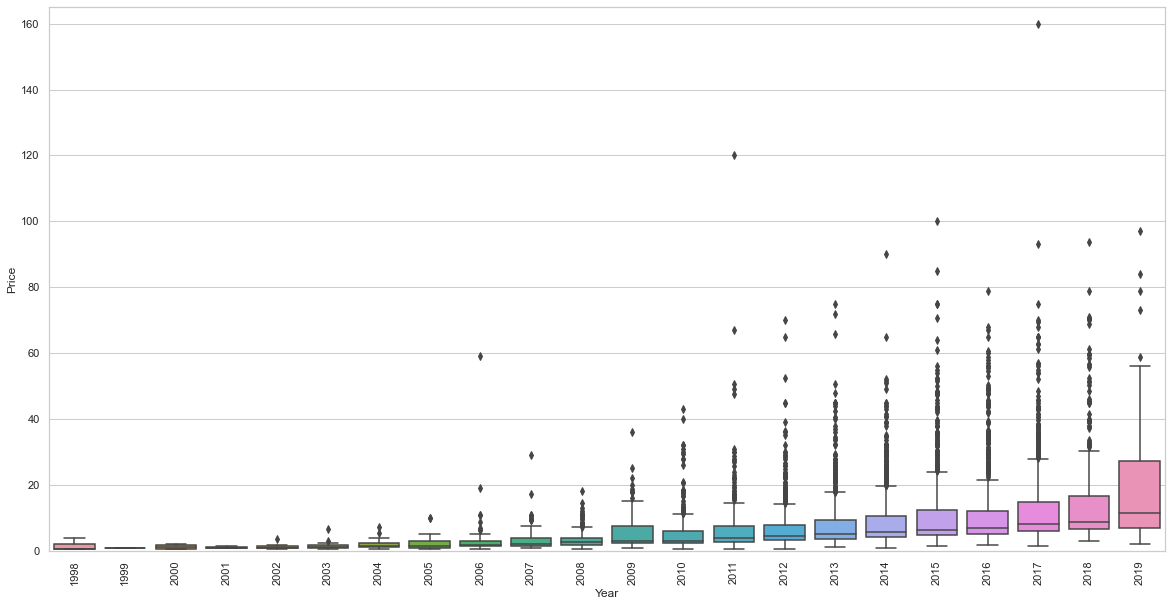

In [26]:
plt.figure(figsize=(20, 10))
fig = sns.boxplot(x='Year', y="Price", data=df_train)
fig.axis(ymin=0, ymax=165)
plt.xticks(rotation=90)
plt.show()

* We can see from the above plotted boxplot, as the year increases price of cars also increases. In short Price of Newest models is high compared to old models.

In [27]:
# lets create a feature age = current year - year
current_year = 2021
df_train['Age'] = current_year - df_train['Year']

#### Analysis of Price and Transmission

<Figure size 864x576 with 0 Axes>

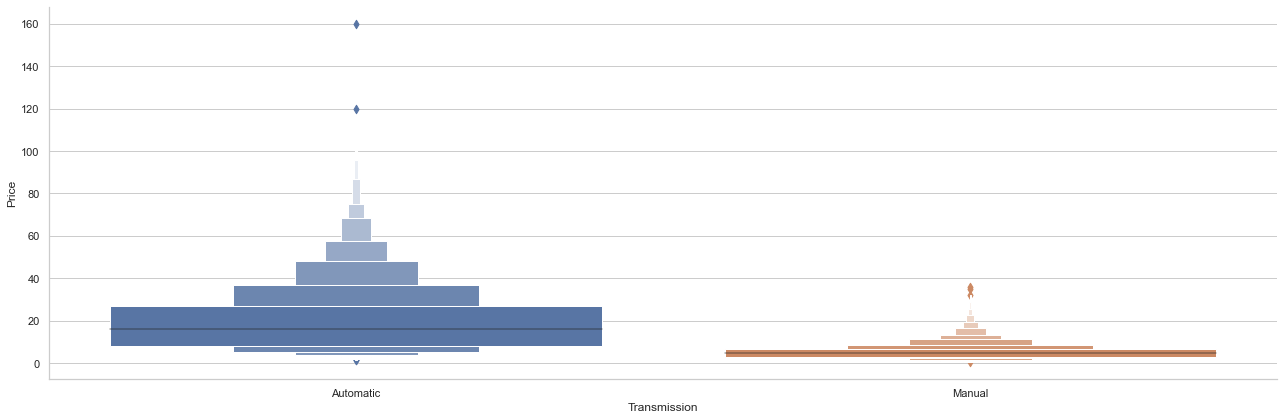

In [28]:
# Plot Transmission vs Price
plt.figure(figsize=(12, 8))
sns.catplot(y='Price',x='Transmission',data= df_train.sort_values('Price',ascending=False),kind="boxen",height=6, aspect=3)
plt.show()

#### Analysis of Price and Fuel Type

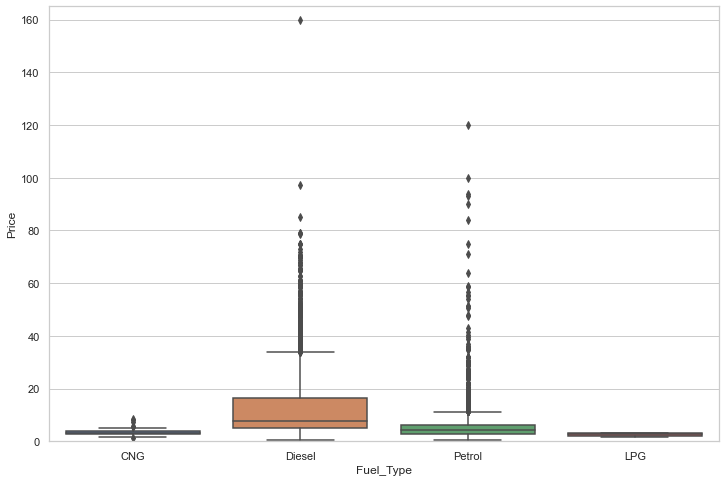

In [29]:
plt.figure(figsize=(12, 8))
fig = sns.boxplot(x='Fuel_Type', y="Price", data=df_train)
fig.axis(ymin=0, ymax=165)
plt.show()

* It is clear from the above figure that the Diesel cars are relatively more costly than the rest.

#### Analysis of Price and Owner Type

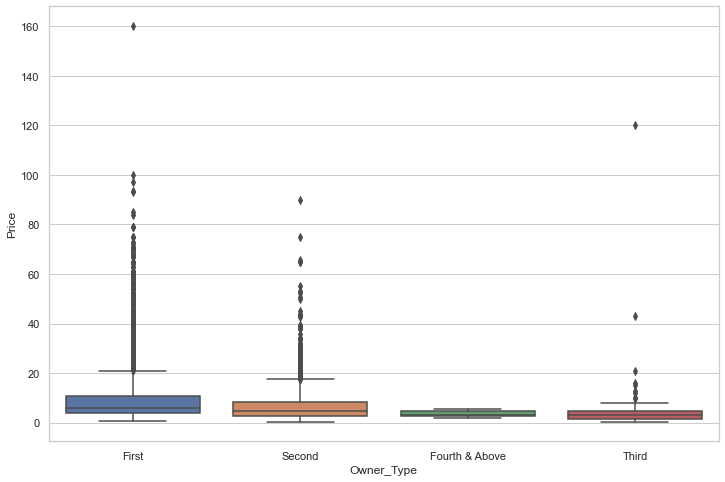

In [30]:
plt.figure(figsize=(12, 8))
fig = sns.boxplot(x='Owner_Type', y="Price", data=df_train)
plt.show()

 * First time owners are more.

#### Analysis of Price and Seats

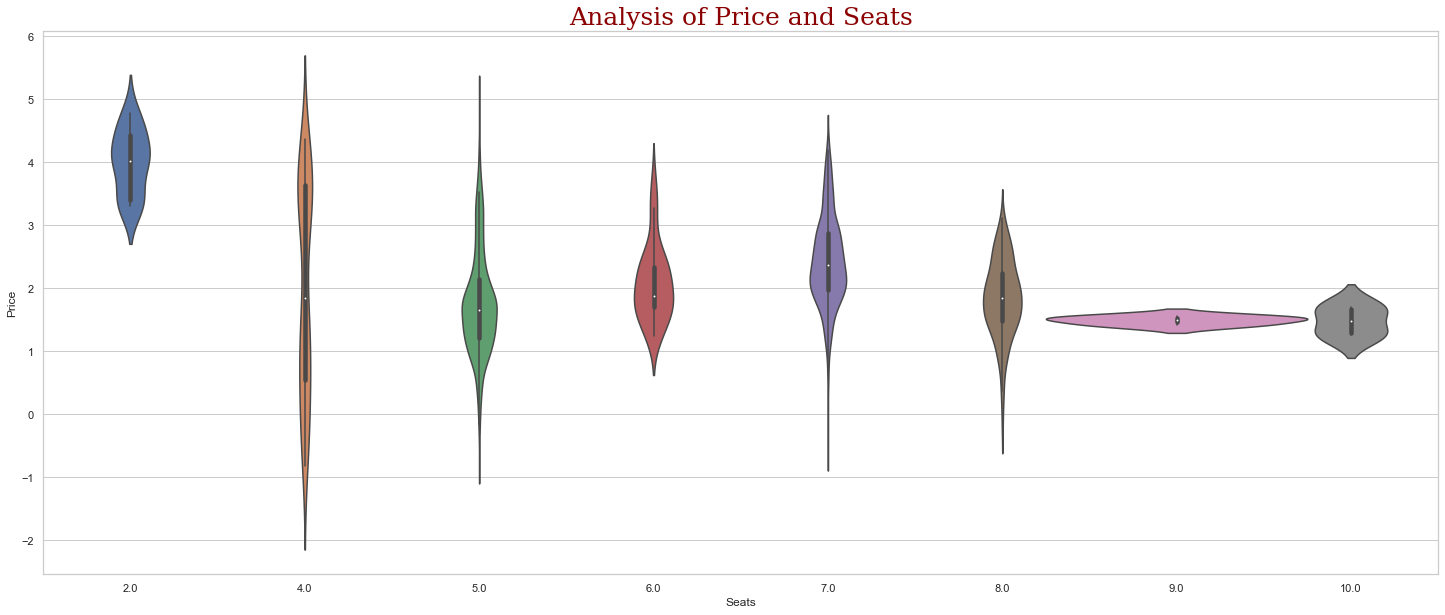

In [31]:
plt.figure(figsize=(25,10))
sns.violinplot(x=df_train['Seats'], y=df_train['Price'].apply(np.log),width=1.5)    
plt.title('Analysis of Price and Seats',fontdict = font, fontsize=25)
plt.show()

* Interestly, mean price for 2-seater vehicle are way higher than the others. lets check the count of each category.

In [32]:
print(df_train['Seats'].value_counts(dropna=False))

5.0     4919
7.0      672
8.0      133
4.0       99
6.0       29
2.0       13
10.0       4
9.0        3
Name: Seats, dtype: int64


* 2 seater vehicle count is comparatively low (just 13), it cannot be universally accepted.

#### Analysis of Price and Continuous Variable

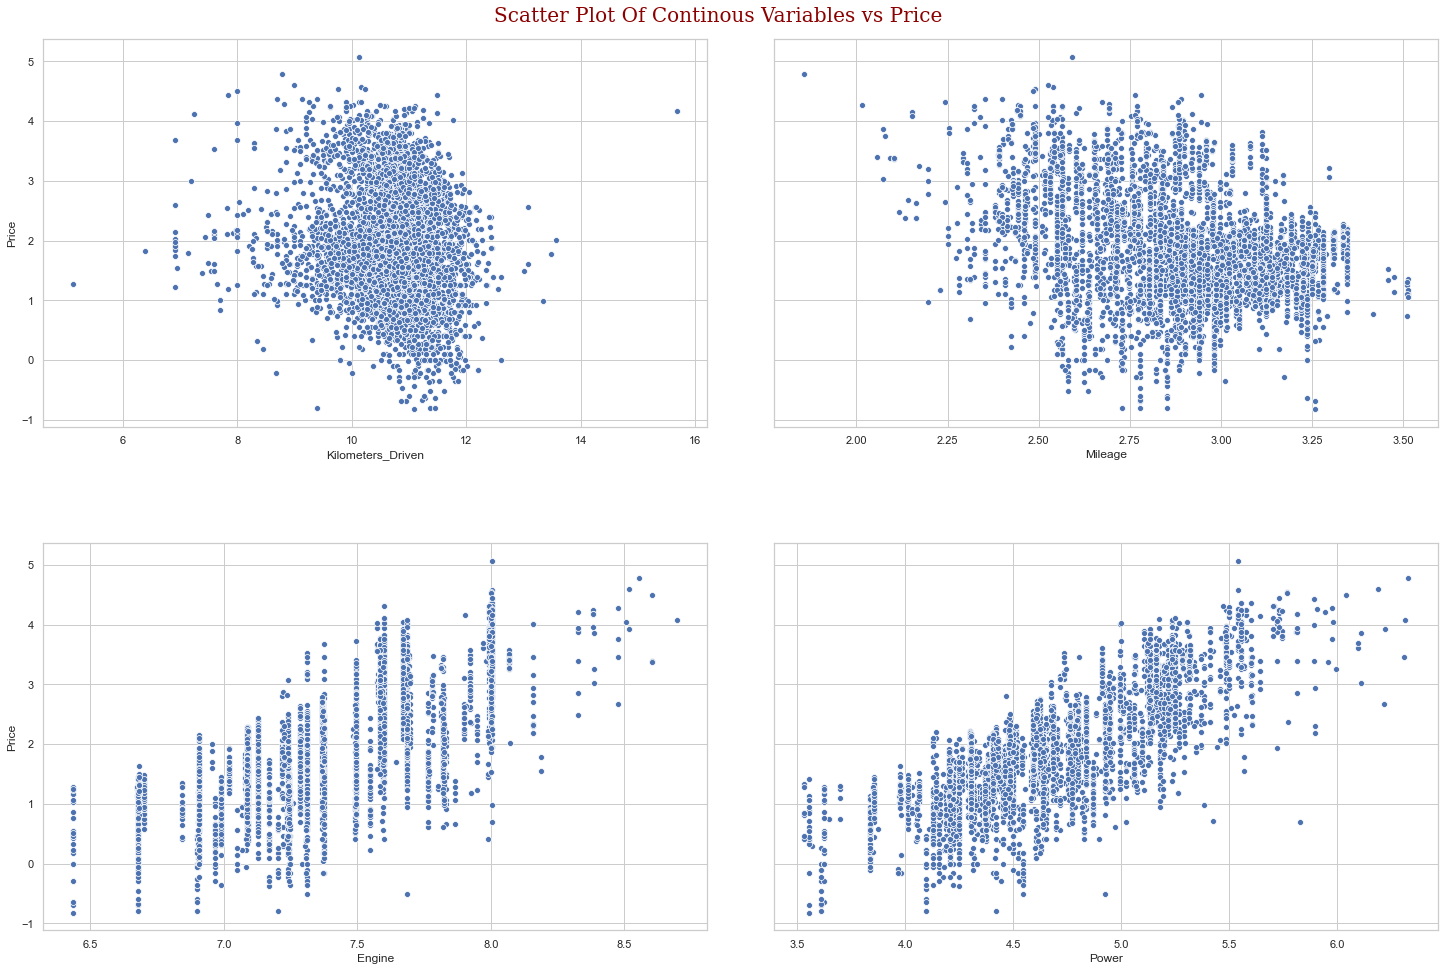

In [33]:

cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power']

fig,axes = plt.subplots(2,2,figsize=(25,15),sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Scatter Plot Of Continous Variables vs Price',fontsize = 20, fontdict=font)
fig.subplots_adjust(top=0.95)

axes = axes.ravel()

for i,col in enumerate(cols):
    #using log transformation
    x = df_train[col].apply(np.log)
    y = df_train['Price'].apply(np.log)
    sns.scatterplot(x, y ,ax=axes[i])
    

* Engine and Power has a strong association with the price.
* Where as Price is not impacted much by Kilometer_driven and Mileage.

In [34]:
df_train.dtypes

Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage              float64
Engine               float64
Power                float64
Seats                float64
Price                float64
Age                    int64
dtype: object

### **Handling Categorical Features**

In [35]:
# Using get_dummies where data are not in any order and LabelEncoder when data is in order.

ordinal_col = 'Owner_Type'
nominal_col = ['Location','Fuel_Type','Transmission']

df_train[ordinal_col].replace({"First":1,"Second":2,"Third": 3,"Fourth & Above":4},inplace=True)
dummies = pd.get_dummies(df_train[nominal_col],drop_first=True)


In [36]:
# concat train and dummies df
df_train = pd.concat([df_train,dummies],axis=1)

# drop the original columns
df_train.drop(nominal_col,axis=1,inplace=True)

# dropping brand names having lot of variation
df_train.drop('Name',axis=1,inplace=True)

### **Handling Numerical Features**

In [37]:
#So our target and numerical features except mileage are positive skewed so have to normalize them first.

def normalize(data,col=None):
    for col in col:
        data[col] = np.log1p(data[col])
        
normalize(df_train,col = ['Price'])

In [38]:
# define MinMaxScaler
scaler = MinMaxScaler()
# transform data
df_train[['Kilometers_Driven','Engine','Mileage','Power']] = scaler.fit_transform(df_train[['Kilometers_Driven','Engine','Mileage','Power']])

In [39]:
# I have decided to drop power beacuse it is correlated with engine.
# also we have already 2 more feature that give us information about the motor: 'Engine', 'Mileage'.
df_train.drop('Power',axis=1,inplace=True)
df_train.drop('Year',axis=1,inplace=True)


In [40]:
df_train.head()

,Kilometers_Driven,Owner_Type,Mileage,Engine,Seats,Price,Age,Location_Bangalore,Location_Chennai,Location_Coimbatore,...,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Manual
0,0.011051,1,0.793083,0.069594,5.0,1.011601,11,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0.006282,1,0.586464,0.178266,5.0,2.602690,6,0,0,0,...,0,0,0,0,0,1,1,0,0,1
2,0.007051,1,0.542636,0.106997,5.0,1.704748,10,0,1,0,...,0,0,0,0,0,0,0,0,1,1
3,0.013359,1,0.619261,0.116115,7.0,1.945910,9,0,1,0,...,0,0,0,0,0,0,1,0,0,1
4,0.006231,2,0.453190,0.250093,5.0,2.930660,8,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [41]:
df_train.shape

(5872, 21)

### **Prepare Test Data**

In [42]:
df_test.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,Maruti Alto K10 LXI CNG,Delhi,2014,40929,CNG,Manual,First,32.26 km/kg,998 CC,58.2 bhp,4.0,NaN
1,Maruti Alto 800 2016-2019 LXI,Coimbatore,2013,54493,Petrol,Manual,Second,24.7 kmpl,796 CC,47.3 bhp,5.0,NaN
2,Toyota Innova Crysta Touring Sport 2.4 MT,Mumbai,2017,34000,Diesel,Manual,First,13.68 kmpl,2393 CC,147.8 bhp,7.0,25.27 Lakh
3,Toyota Etios Liva GD,Hyderabad,2012,139000,Diesel,Manual,First,23.59 kmpl,1364 CC,null bhp,5.0,NaN
4,Hyundai i20 Magna,Mumbai,2014,29000,Petrol,Manual,First,18.5 kmpl,1197 CC,82.85 bhp,5.0,NaN


In [43]:
print('Shape of Test Data Before Dropping Any Row: ',df_test.shape)
# Let's Drop those Rows which contains NULL values.
# dropping New_Price as there are many cell which contains NULL value in this column.
df_test.drop('New_Price',axis=1,inplace=True)

df_test.dropna(inplace=True)

remove_units(df_test,col = ['Name','Mileage','Engine','Power'])

# changing datatype from string to float
for col in ['Mileage','Engine']:
    df_test[col] = df_test[col].astype(float)

## dropping the rows having string null in Power column
null_index_test = df_test[df_test['Power'] == 'null'].index
df_test.drop(null_index_test,inplace=True)   

df_test['Power'] = df_test['Power'].astype(float)
# lets create a feature age = current year - year
current_year = 2021
df_test['Age'] = current_year - df_test['Year']

# Using get_dummies where data are not in any order and LabelEncoder when data is in order.

df_test[ordinal_col].replace({"First":1,"Second":2,"Third": 3,"Fourth & Above":4},inplace=True)
dummies_test = pd.get_dummies(df_test[nominal_col],drop_first=True)

# concat test and test dummies df
df_test = pd.concat([df_test,dummies_test],axis=1)

# drop the original columns
df_test.drop(nominal_col,axis=1,inplace=True)

# dropping brand names having lot of variation
df_test.drop('Name',axis=1,inplace=True) 

# normalize(df_test,col = ['Kilometers_Driven','Engine','Power'])
# transform data
df_test[['Kilometers_Driven','Engine','Mileage','Power']] = scaler.transform(df_test[['Kilometers_Driven','Engine','Mileage','Power']])

# I decided to drop Power because we have already 2 more feature that give us information about the motor: 'Engine', 'Mileage'.
df_test.drop('Power',axis=1,inplace=True) 
df_test.drop('Year',axis=1,inplace=True)
print('Shape of Test Data After Dropping Rows: ',df_test.shape)

Shape of Test Data Before Dropping Any Row:  (1234, 12)
Shape of Test Data After Dropping Rows:  (1201, 20)


### **Model Building**

#### Separate Dependent and Independent Variables

In [44]:
X = df_train.drop('Price',axis=1)
y = df_train['Price']

#### Train-Test Split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 50)

### Linear Regression

In [46]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(X_train,y_train)
pred_lr = lr.predict(X_test)
print("MSE on validation:", mean_squared_error(y_test, pred_lr))

MSE on validation: 0.08120984850788993


### Random Forest

In [47]:
rf = RandomForestRegressor(n_estimators=300, max_depth = 20, random_state=50)
rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)

In [48]:
print("MSE on training:", mean_squared_error(y_train, y_pred_train))

y_pred_valid = rf.predict(X_test)

print("MSE on validation:", mean_squared_error(y_test, y_pred_valid))

MSE on training: 0.0064347222842034155
MSE on validation: 0.04020446799064552


#### Lets try one more model

### XGBoost

In [49]:
xgb = XGBRegressor()

param_grid = {
    "booster": ['gbtree'],
    "eta": [0.01],
    "gamma": [0],
    "max_depth": [5],
    "lambda": [0],
    "alpha": [0]
}

xgb_model = GridSearchCV(estimator=xgb, cv=5, param_grid=param_grid)
xgb_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [50]:
y_pred_train_xgb = xgb_model.predict(X_train)

print("MSE on training:", mean_squared_error(y_train, y_pred_train_xgb))

y_pred_valid_xgb = xgb_model.predict(X_test)

print("MSE on validation:", mean_squared_error(y_test, y_pred_valid_xgb))

MSE on training: 0.44482045258779185
MSE on validation: 0.4795235140002298


**From Random Forest  we got a a very low MSE, so it will be a better model for us.**

### Prediction on Test Data

In [51]:
# All predictions by the model will then be in log values 
# we will need to take the antilog to get the actual value.
rf_pred = np.floor(np.expm1(rf.predict(df_test)))